In [1]:
import numpy as np
from scipy.fftpack import dct, idct

import scipy.io
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from helper_functions.helper_functions import plt3D2

import svd_model as svm

import forward_model as fm
import cv2 as cv

# Field-varying forward model

In this notebook, you can upload your measured PSFs across the FoV. At each depth, the measured PSFs will be registered and the SVD parameters will be computed. These parameters (comps, weights) can be used to generate simulated measurements taking into account field varying aberrations. In our experiments, we measure an 8x8 grid (64 PSFs) at each depth and use rank 12. In this tutorial, we include a downsampled version measured on a 3x3 grid (9 PSFs) at 40 depths. 


## Load in measured PSFs

PSFs are expected to have a shape of (x,y,P,z), where P is the number of samples at a given depth, and z is the number of depths. Here PSFs have a shape of (486, 648, 9, 40).

In [2]:
registered_psfs_path = '/home/kyrollos//LearnedMiniscope3D/MultiWiener/multiwienernet/data/PSFs/9_psfs/multiWienerPSFStack_40z.mat'
psf_name='multiWienerPSFStack_40z'

loaded_matfile = scipy.io.loadmat(registered_psfs_path)
psfs=loaded_matfile[psf_name]
print(psfs.shape)

(486, 648, 9, 40)


## Registering the PFSs

In order to calcualte SVD model parameters, we need to register the PSFs. This registration is done at each depth. We pick the PSF sampled from the middle of the FoV as the reference image and register other PSFs to it. Here we show how this is done at one depth (z=0). If wokring with 3D PSFs, you will need to repeat this for each depth. 

In addition, if the PFSs contain some background, we implement a discrete cosine transform background subtraction. This is tuned to our PSFs and is optional. Set dct_on=True or False to enable or disable it. 

In [3]:
# register the PSFs and calculate their shifts
depth=0
ref_image_index=4
psfs_reg,shifts=svm.register_psfs(psfs[:,:,:,depth],psfs[:,:,ref_image_index,depth],dct_on=True)

Removing background

done

registering

done registering



## Calculating SVD model parameters

Using the registered PSFs and the shifts, we can now perfrom SVD up to a chosen rank less thank the number of image sampled per depth. Here we have 9 images per depth, so we chose a rank of 4. The higher the rank, the better the model but the slower the FISTA SVD algorithm. 

In [4]:
rank=4
comps, weights_interp=svm.calc_svd(psfs_reg,shifts,rank)

creating matrix

done

starting svd...

check values of ymat
interpolating...

done




## Let's visualize the weights and components


In [5]:
plt3D2(comps)

interactive(children=(IntSlider(value=1, description='r', max=3), Output()), _dom_classes=('widget-interact',)…

In [6]:
plt3D2(weights_interp)

interactive(children=(IntSlider(value=1, description='r', max=3), Output()), _dom_classes=('widget-interact',)…

## simulate data using forward model

In [7]:
#make the shape, xyzr or xyr if 2D
# Normalize weights to have maximum sum through rank of 1
weights_norm = np.sum(weights_interp[weights_interp.shape[0]//2-1,weights_interp.shape[1]//2-1,:],0).max()
weights = weights_interp/weights_norm;

#normalize by norm of all stack. Can also try normalizing by max of all stack or by norm of each slice
h=comps/np.linalg.norm(np.ravel(comps))

In [8]:
# padded values for 2D
ccL = np.shape(h)[1]//2
ccU = 3*np.shape(h)[1]//2
rcL = np.shape(h)[0]//2
rcU = 3*np.shape(h)[0]//2

H=np.ndarray((np.shape(h)[0]*2,np.shape(h)[1]*2,np.shape(h)[2]), dtype=complex)
Hconj=np.ndarray((np.shape(h)[0]*2,np.shape(h)[1]*2,np.shape(h)[2]),dtype=complex)
for i in range (np.shape(h)[2]):
        H[:,:,i]=(np.fft.fft2(fm.pad2d(h[:,:,i])))
        Hconj[:,:,i]=(np.conj(H[:,:,i]))

In [10]:
x=(plt.imread('/home/kyrollos/MultiWienerNet/data/hydra3.jpg'))
x=cv.resize(x,(h.shape[1],h.shape[0]))
x=np.mean(x,2)

In [14]:
sim=fm.A_2d_svd_crop(fm.pad2d(x),H,weights,fm.pad2d,[rcL,rcU,ccL,ccU],mode='shift_variant')

Text(0.5, 1.0, 'Simulated Measurement')

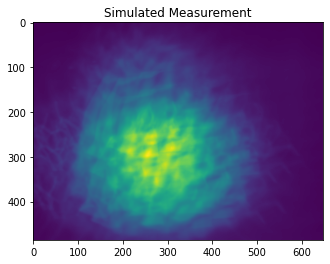

In [15]:
plt.imshow(sim)
plt.title('Simulated Measurement')